# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Proyecto Integrador**

### Tecnológico de Monterrey

## Actividad Semana 6

### **Actividad 4. Modelos Alternativos**

Nombres y matrículas de los integrantes del equipo:
* Adrián Alejandro Dávila González - A01039334
* Samuel Emanuel Aguilar García - A00816565

## **Actividades Iniciales**

El propósito de este documento es el realizar los diferentes entrenamientos de manera secuencial de los modelos. Los resultados se guardarán en un archivo para poderlos desplegar en la libreta final.

### **Importado de Librerías a Utilizar**

In [1]:
# Montaje de Libreta en Entorno de Google Collaboratory.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting the locale to UTF-8 to avoid the NotImplementedError
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
# Importado de Librerías.
import os
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as T
from pycocotools.coco import COCO
from torchvision.datasets import CocoDetection
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Definición de Ruta en Directorios.
Main_Dir= "/content/drive/MyDrive/Maestría/Sexto Trimestre/Proyecto Integrador/Semana 5"
Modelo_3 = os.path.join(Main_Dir, "Dataset R-CNN")

# Definir las rutas a las carpetas de imágenes y archivos de anotaciones COCO
train_img_dir = os.path.join(Modelo_3, "train/images")
train_ann_file = os.path.join(Modelo_3, "train/_annotations.coco.json")

val_img_dir = os.path.join(Modelo_3, "valid/images")
val_ann_file = os.path.join(Modelo_3, "valid/_annotations.coco.json")

test_img_dir = os.path.join(Modelo_3, "test/images")
test_ann_file = os.path.join(Modelo_3, "test/_annotations.coco.json")

os.chdir(Main_Dir)

# **Modelo Fast R-CNN**

A continuación se entrenaran el modelo Fast R-CNN usando el mismo dataset. A este se le realizó modificaciones en formato para poderlo leer usando este modelo.

### Clase personalizada

In [6]:
# Crear la clase personalizada para cargar el dataset
class COCODataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super(COCODataset, self).__init__(img_folder, ann_file)
        self.transforms = transforms
        self.coco = COCO(ann_file)

    def __getitem__(self, idx):
        img, target = super(COCODataset, self).__getitem__(idx)

        # Convertir las anotaciones en el formato requerido por Faster R-CNN
        image_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []

        for ann in annotations:
            x, y, width, height = ann['bbox']
            boxes.append([x, y, x + width, y + height])
            labels.append(ann['category_id'])

        # Convertir a tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

### Redimensionar las imágenes

In [7]:
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Redimensionar todas las imágenes para que tengan el mismo tamaño (640x640 en este caso)
    transform = T.Resize((640, 640))
    images = [transform(image) for image in images]

    # Convertir las imágenes a tensores
    images = torch.stack([T.ToTensor()(img) for img in images], dim=0)

    return images, targets

### Crear Datasets y DataLoaders

In [8]:
# Crear datasets con las rutas de imágenes y anotaciones
train_dataset = COCODataset(train_img_dir, train_ann_file)
val_dataset = COCODataset(val_img_dir, val_ann_file)
test_dataset = COCODataset(test_img_dir, test_ann_file)

# Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

loading annotations into memory...
Done (t=1.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Función para el entrenamiento

In [9]:
# Función de entrenamiento
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    running_loss = 0.0
    for images, targets in data_loader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    return running_loss / len(data_loader)

### Función para el cálculo de métricas

In [10]:
# Función para calcular precisión y recall del modelo
def calculate_precision_and_recall(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            outputs = model(images)

            for i, output in enumerate(outputs):
                true_labels = targets[i]['labels'].cpu().numpy()

                if len(output['labels']) > 0:  # Si hay predicciones
                    pred_labels = output['labels'].cpu().numpy()
                    all_preds.extend(pred_labels)
                    all_labels.extend(true_labels)
                else:
                    # Si no hay predicciones, solo agregar etiquetas verdaderas
                    all_labels.extend(true_labels)

    # Convertir a arreglos numpy
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Asegurarse de que las longitudes sean consistentes
    if len(all_labels) == 0:
        print("Warning: No true labels found.")
        return 0.0, 0.0, None  # Retornar 0 si no hay etiquetas verdaderas

    if len(all_preds) == 0:
        print("Warning: No predictions found.")
        return 0.0, 0.0, None  # Retornar 0 si no hay predicciones

    # Filtrar etiquetas y predicciones para que coincidan en longitud
    min_length = min(len(all_labels), len(all_preds))
    all_labels = all_labels[:min_length]
    all_preds = all_preds[:min_length]

    # Calcular precisión, recall y matriz de confusión
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    matrix = confusion_matrix(all_labels, all_preds)

    return precision, recall, matrix

In [11]:
# Guardar la matriz de confusión como una imagen
def save_confusion_matrix(matrix, file_path):
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.savefig(file_path)
    print(f"Confusion matrix saved to {file_path}")

### Función para guardar resultados

In [12]:
# Guardar resultados en un archivo CSV
def save_results_to_csv(results, file_path):
    df = pd.DataFrame(results)
    df.to_csv(file_path, index=False)
    print(f"Results saved to {file_path}")

### **Entrenamiento y guardar metricas**

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 184MB/s]


Epoch 1, Loss: 1.1226, Precision: 0.3615, Recall: 0.3313, Time: 54.29 sec
Epoch 2, Loss: 0.7716, Precision: 0.3566, Recall: 0.3546, Time: 27.09 sec
Epoch 3, Loss: 0.6877, Precision: 0.3500, Recall: 0.3305, Time: 27.15 sec
Epoch 4, Loss: 0.6206, Precision: 0.3430, Recall: 0.3244, Time: 27.00 sec
Epoch 5, Loss: 0.5767, Precision: 0.3220, Recall: 0.2874, Time: 26.96 sec
Epoch 6, Loss: 0.5280, Precision: 0.3372, Recall: 0.3158, Time: 27.03 sec
Epoch 7, Loss: 0.4844, Precision: 0.3132, Recall: 0.2952, Time: 26.99 sec
Epoch 8, Loss: 0.4542, Precision: 0.3436, Recall: 0.3296, Time: 27.02 sec
Epoch 9, Loss: 0.4319, Precision: 0.3095, Recall: 0.2960, Time: 26.95 sec
Epoch 10, Loss: 0.3981, Precision: 0.3188, Recall: 0.3115, Time: 27.05 sec
Epoch 11, Loss: 0.3815, Precision: 0.3575, Recall: 0.3468, Time: 27.06 sec
Epoch 12, Loss: 0.3450, Precision: 0.3309, Recall: 0.3219, Time: 27.06 sec
Epoch 13, Loss: 0.3224, Precision: 0.2951, Recall: 0.2849, Time: 27.06 sec
Epoch 14, Loss: 0.3202, Precision:

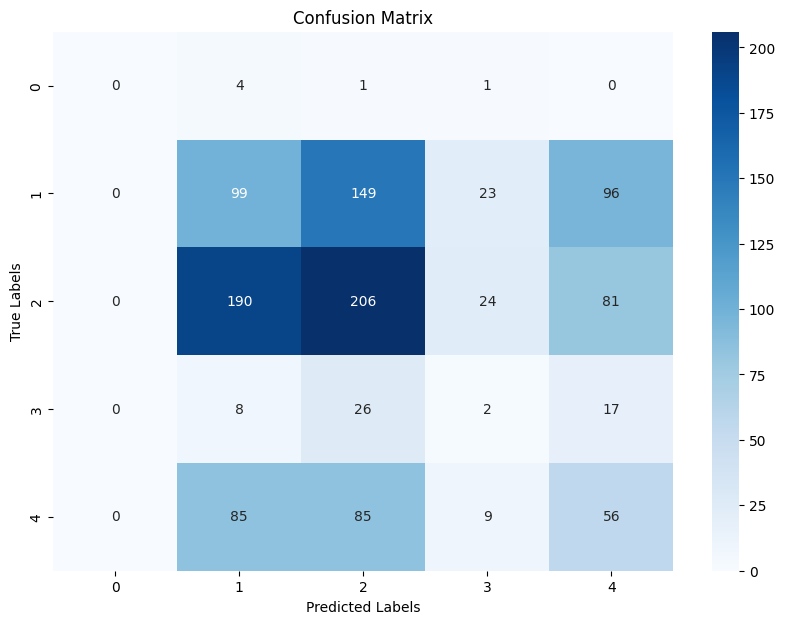

In [13]:
# Entrenamiento del modelo Faster R-CNN
if __name__ == "__main__":
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

    num_epochs = 100
    results = []

    for epoch in range(num_epochs):
        start_time = time.time()

        # Entrenar una época
        train_loss = train_one_epoch(model, optimizer, train_loader, device)

        # Calcular precisión y recall para cada época
        precision, recall, matrix = calculate_precision_and_recall(model, val_loader, device)

        # Calcular tiempo de ejecución de la época
        epoch_time = time.time() - start_time

        # Guardar los resultados de esta época en la lista
        results.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'precision': precision,
            'recall': recall,
            'epoch_time': epoch_time
        })

        print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f} sec")

    # Guardar los resultados en un archivo CSV
    save_results_to_csv(results, 'training_results.csv')

    # Guardar la matriz de confusión al finalizar el entrenamiento
    if matrix is not None:
        save_confusion_matrix(matrix, 'confusion_matrix.png')

Confusion matrix saved to confusion_matrix.png


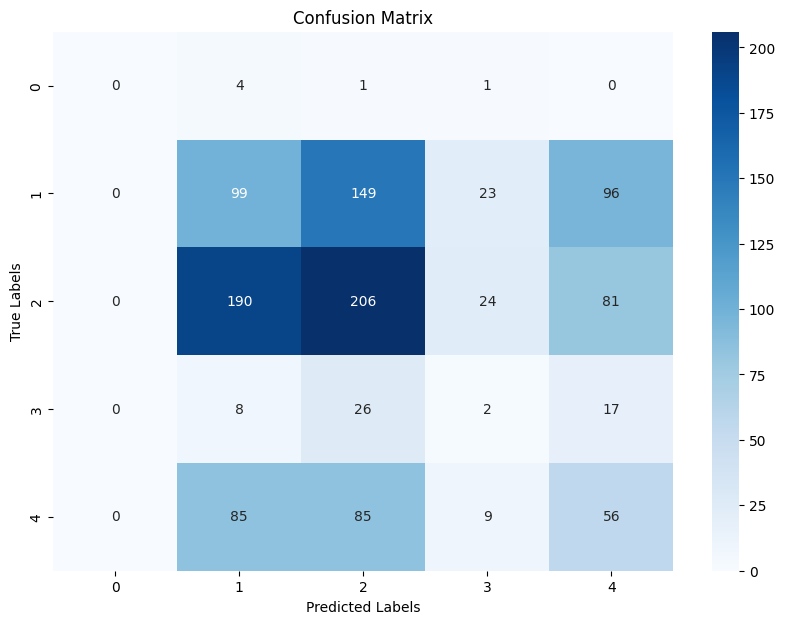

In [14]:
    if matrix is not None:
        save_confusion_matrix(matrix, 'confusion_matrix.png')